In [217]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime

import seaborn as sns
from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image


# Helper Functions

In [194]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [195]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\anaconda3\envs\Scraping\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Web scraping HMH web site

In [196]:
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
page = requests.get(url, headers=headers)

In [197]:
# Html 
soup = BeautifulSoup( page.text, 'html.parser')

In [198]:
#min max product in the home page
min_product = soup.find('h2', class_='load-more-heading').get('data-items-shown')
max_product = soup.find('h2', class_='load-more-heading').get('data-total')

In [199]:
# Dinamic link to run all pages
total_page = soup.find('a', class_='pagination-links-list').get('href')

In [200]:
#offset = 0 and Zise = max_product to show all products in the first page
total_page = 'https://www2.hm.com/en_us/men/products/jeans.html?offset=0&page-size=' + max_product

In [201]:
# The Home page with all products
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
page = requests.get(total_page, headers=headers)

In [202]:
soup = BeautifulSoup( page.text, 'html.parser')

In [203]:
#all my products
products = soup.find('ul', class_='products-listing small')

In [204]:
products.get('href')

In [205]:
product_list = products.find_all('a', class_='link')

In [206]:
product_list[0].get('href')

'/en_us/productpage.0636207006.html'

In [207]:
# All products links 
product_links = [p.get('href') for p in product_list]

In [208]:
# Get the link of the variation colors product inside the product link

list_total_links =[]
for p in range(len(product_links)):
    
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    page = requests.get('https://www2.hm.com' + product_links[p], headers=headers)
    soup = BeautifulSoup( page.text, 'html.parser')
    
    product = soup.find('ul', class_='inputlist clearfix')
    list_product = product.find_all('a', class_='filter-option miniature')
    list_product_links = [p.get('href') for p in list_product]
    
    list_total_links = list_total_links + list_product_links 
 

In [209]:
#Total links
len(list_total_links)

631

In [210]:
#remove duplicates links
list_total_links =list(dict.fromkeys(list_total_links))

In [211]:
#Total links
len(list_total_links)

192

In [215]:
#create empty dataframe to insert the features values of the product

columns = ['product_id', 'product_name', 'product_price', 'product_color', 'product_composition', 'product_fit']
df = pd.DataFrame(columns=columns)

In [218]:
#Get all values

for p in range(len(list_total_links)):
     
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    page = requests.get('https://www2.hm.com' + list_total_links[p], headers=headers)
    soup = BeautifulSoup( page.text, 'html.parser')
    
    print(list_total_links[p])
    
    product_price = soup.find('div', class_='price parbase')
    
    # confirm if the product exist
    if product_price is None:
        continue
        
    # get price
    product_price = soup.find('div', class_='price parbase')
    product_price = list(filter(None,product_price.get_text().split('\n')))
    
    #get name
    product_name = soup.find('h1', class_='primary product-item-headline')
    product_name = list(filter(None,product_name.get_text().split('\t')))
    
    #get color
    product_color = soup.find('title')
    product_color = product_color.get_text().split('-')
    
    # product fit / id / composition
    product_info = soup.find_all('div', class_='pdp-description-list-item')
    
    #Create a dictionary  
    x = {}
    for i in range(len(product_info)):
    
        x[list(filter(None,product_info[i].get_text().split('\n')))[0]] = list(filter(None,product_info[i].get_text().split('\n')))[1]
    
    # check if exist composition values
    
    if('Fit' in x):
        product_fit =x['Fit']
    
    if('Art. No.' in x):
        product_id  =x['Art. No.']
    
    if('Composition' in x):
        product_composition =x['Composition']
    

    df.loc[p, 'product_id']          = product_id 
    df.loc[p, 'product_name']        = product_name[1].strip()
    df.loc[p, 'product_price']       = product_price[1].strip()
    df.loc[p, 'product_color']       = product_color[1].strip()
    df.loc[p, 'product_composition'] = product_composition 
    df.loc[p, 'product_fit']         = product_fit 

    df['scrapy_day_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')


/en_us/productpage.0636207001.html
/en_us/productpage.0636207002.html
/en_us/productpage.0636207004.html
/en_us/productpage.0636207005.html
/en_us/productpage.0636207010.html
/en_us/productpage.0636207011.html
/en_us/productpage.0636207014.html
/en_us/productpage.0636207015.html
/en_us/productpage.0636207017.html
/en_us/productpage.0636207019.html
/en_us/productpage.0636207006.html
/en_us/productpage.0427159001.html
/en_us/productpage.0427159002.html
/en_us/productpage.0427159003.html
/en_us/productpage.0427159004.html
/en_us/productpage.0427159005.html
/en_us/productpage.0427159007.html
/en_us/productpage.0427159008.html
/en_us/productpage.0427159010.html
/en_us/productpage.0427159011.html
/en_us/productpage.0427159017.html
/en_us/productpage.0427159022.html
/en_us/productpage.0427159023.html
/en_us/productpage.0427159025.html
/en_us/productpage.0427159027.html
/en_us/productpage.0690449001.html
/en_us/productpage.0690449002.html
/en_us/productpage.0690449006.html
/en_us/productpage.0

# 1.0. Descriptive Data

In [219]:
df

,product_id,product_name,product_price,product_color,product_composition,product_fit,scrapy_day_time
0,0636207001,Slim Jeans,$19.99,Dark denim blue,"Cotton 89%, Polyester 10%, Elastane 1%",Slim fit,2021-04-24 14:59:48
1,0636207002,Slim Jeans,$5.99,Dark gray denim,"Cotton 66%, Polyester 28%, Viscose 5%, Elastan...",Slim fit,2021-04-24 14:59:48
2,0636207004,Slim Jeans,$10.99,Denim blue,"Cotton 88%, Polyester 10%, Elastane 2%",Slim fit,2021-04-24 14:59:48
3,0636207005,Slim Jeans,$11.99,Gray,Pocket lining: Cotton 100%,Slim fit,2021-04-24 14:59:48
4,0636207010,Slim Jeans,$19.99,Light denim blue,"Cotton 88%, Polyester 10%, Elastane 2%",Slim fit,2021-04-24 14:59:48
5,0636207011,Slim Jeans,$19.99,Midnight blue,"Pocket lining: Polyester 65%, Cotton 35%",Slim fit,2021-04-24 14:59:48
6,0636207014,Slim Jeans,$19.99,Dark gray,"Cotton 99%, Elastane 1%",Slim fit,2021-04-24 14:59:48
7,0636207015,Slim Jeans,$19.99,Denim blue,"Cotton 89%, Polyester 10%, Elastane 1%",Slim fit,2021-04-24 14:59:48
8,0636207017,Slim Jeans,$19.99,White,"Cotton 88%, Polyester 10%, Elastane 2%",Slim fit,2021-04-24 14:59:48
9,0636207019,Slim Jeans,$19.99,Pale denim blue,Pocket lining: Cotton 100%,Slim fit,2021-04-24 14:59:48


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 191
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           191 non-null    int64  
 1   product_name         191 non-null    object 
 2   product_price        191 non-null    float64
 3   product_color        191 non-null    object 
 4   product_composition  191 non-null    object 
 5   product_fit          191 non-null    object 
 6   scrapy_day_time      191 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 16.0+ KB


In [ ]:
df['product_price'] = df['product_price'].map(lambda x: x.lstrip('$').rstrip(''))

In [114]:
df['product_id'] = df['product_id'].astype('int64')
df['product_price'] = df['product_price'].astype('float64')

## 1.1. Data Dimensions

In [38]:
print('Number of Rows: {}'.format( df.shape[0]))
print('Number of Cols: {}'.format( df.shape[1]))

Number of Rows: 191
Number of Cols: 7


# 2.0.  EDA

## 2.1. univariate analysis price

In [169]:
df1 = df

In [170]:
df1['product_price'].describe()

count    191.000000
mean      26.492618
std       11.075756
min        5.990000
25%       18.990000
50%       24.990000
75%       29.990000
max       49.990000
Name: product_price, dtype: float64

<AxesSubplot:xlabel='product_price', ylabel='Count'>

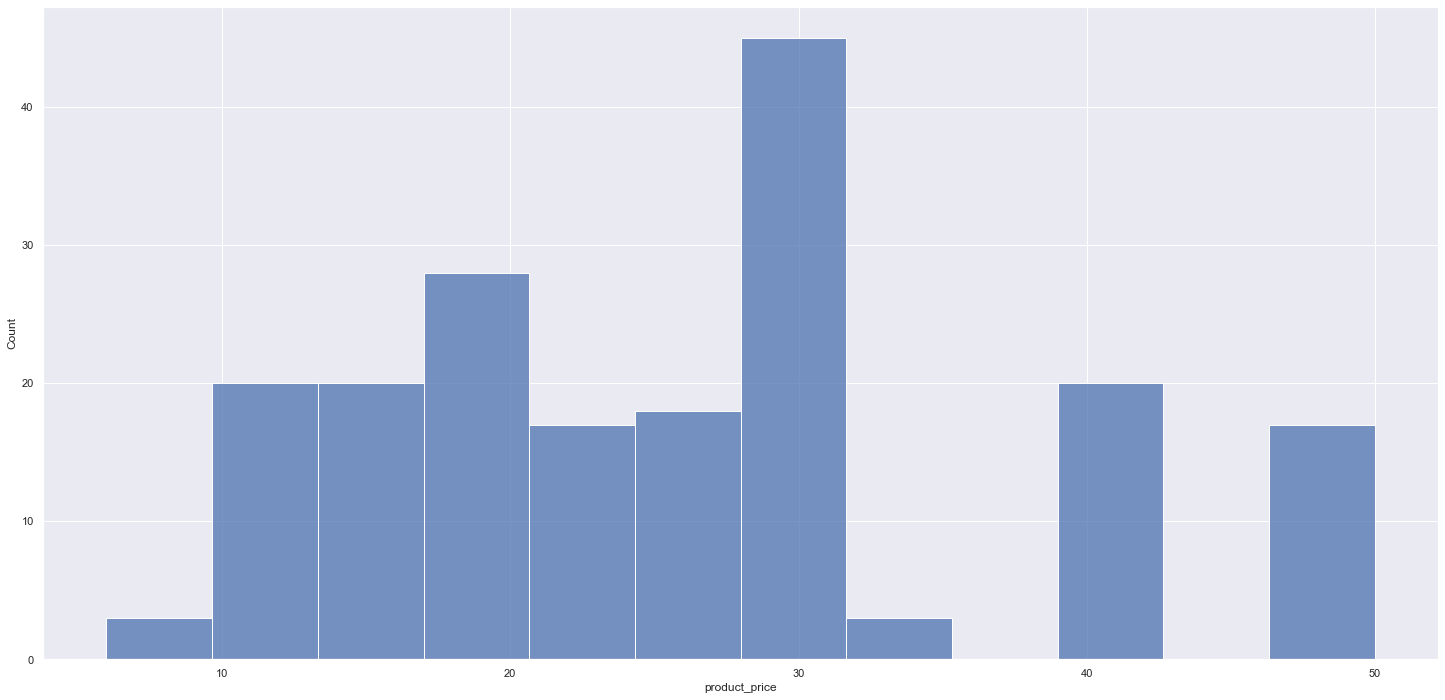

In [148]:
sns.histplot(df1['product_price'], kde= False)

## 2.2. bivariate analysis

### 2.2.1 Number of product by the class name 

In [149]:
aux1 = df[['product_name','product_id' ]].groupby('product_name').count().reset_index()

In [150]:
aux1.sort_values(by=['product_id'], ascending=False)

,product_name,product_id
12,Skinny Jeans,64
13,Slim Jeans,25
18,Trashed Skinny Jeans,20
5,Regular Jeans,13
2,Freefit® Slim Jeans,10
15,Slim Tapered Jeans,7
11,Skinny Cropped Jeans,7
10,Relaxed Tapered Pull-on Jeans,5
17,Tapered Jeans,5
7,Regular Tapered Crop Jeans,5


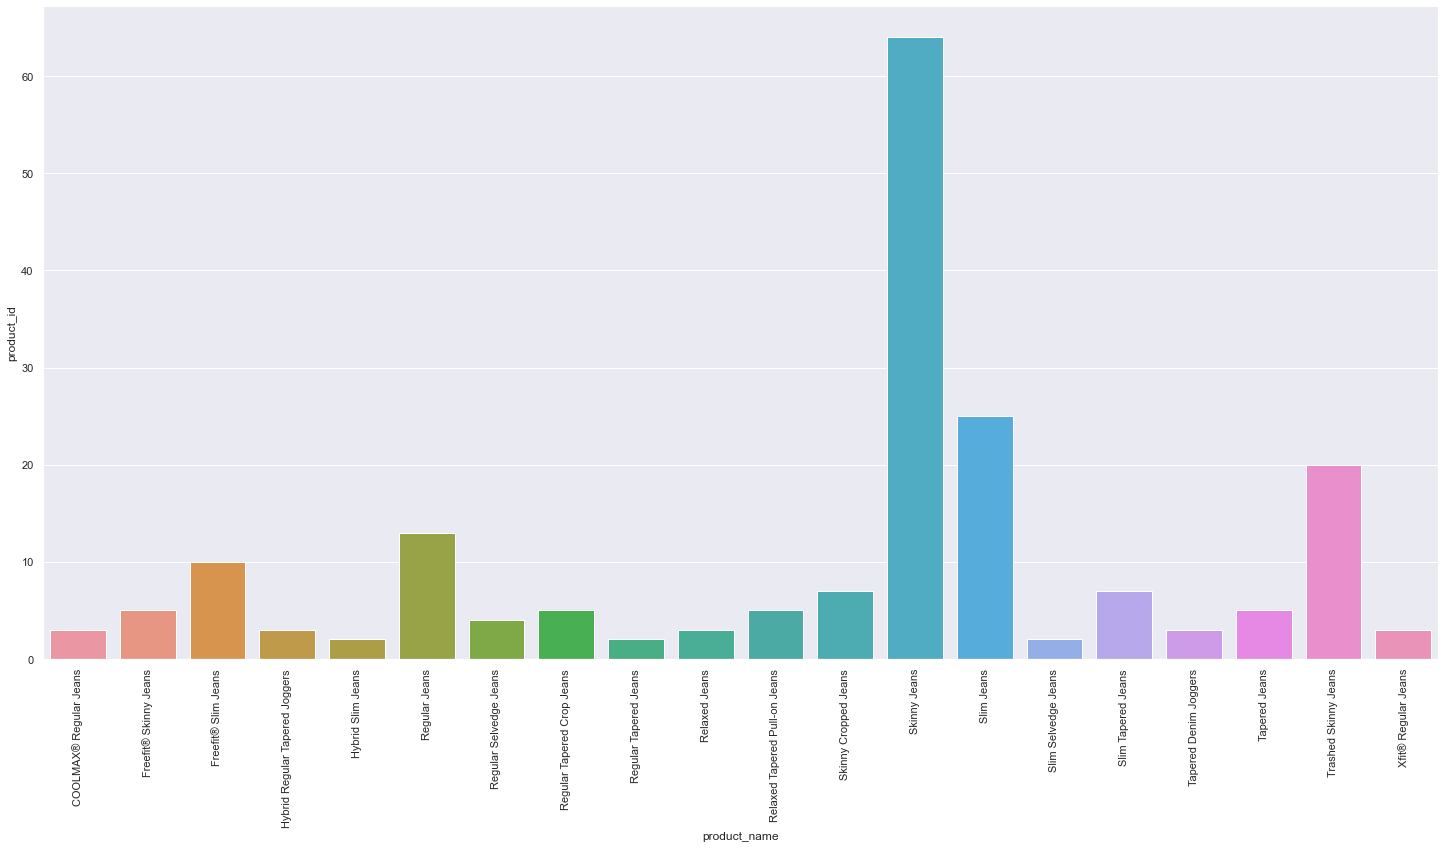

In [157]:
sns.barplot(x ='product_name' , y= 'product_id', data=aux1)
plt.xticks(rotation=90);

### 2.2.2 Median price by product class name

In [163]:
aux2 = df[['product_name','product_price']].groupby('product_name').median().reset_index()

In [164]:
aux2.sort_values(by=['product_price'], ascending=False)

,product_name,product_price
19,Xfit® Regular Jeans,49.99
2,Freefit® Slim Jeans,49.99
1,Freefit® Skinny Jeans,49.99
4,Hybrid Slim Jeans,39.99
0,COOLMAX® Regular Jeans,39.99
3,Hybrid Regular Tapered Joggers,39.99
6,Regular Selvedge Jeans,39.49
14,Slim Selvedge Jeans,38.49
5,Regular Jeans,29.99
8,Regular Tapered Jeans,29.99


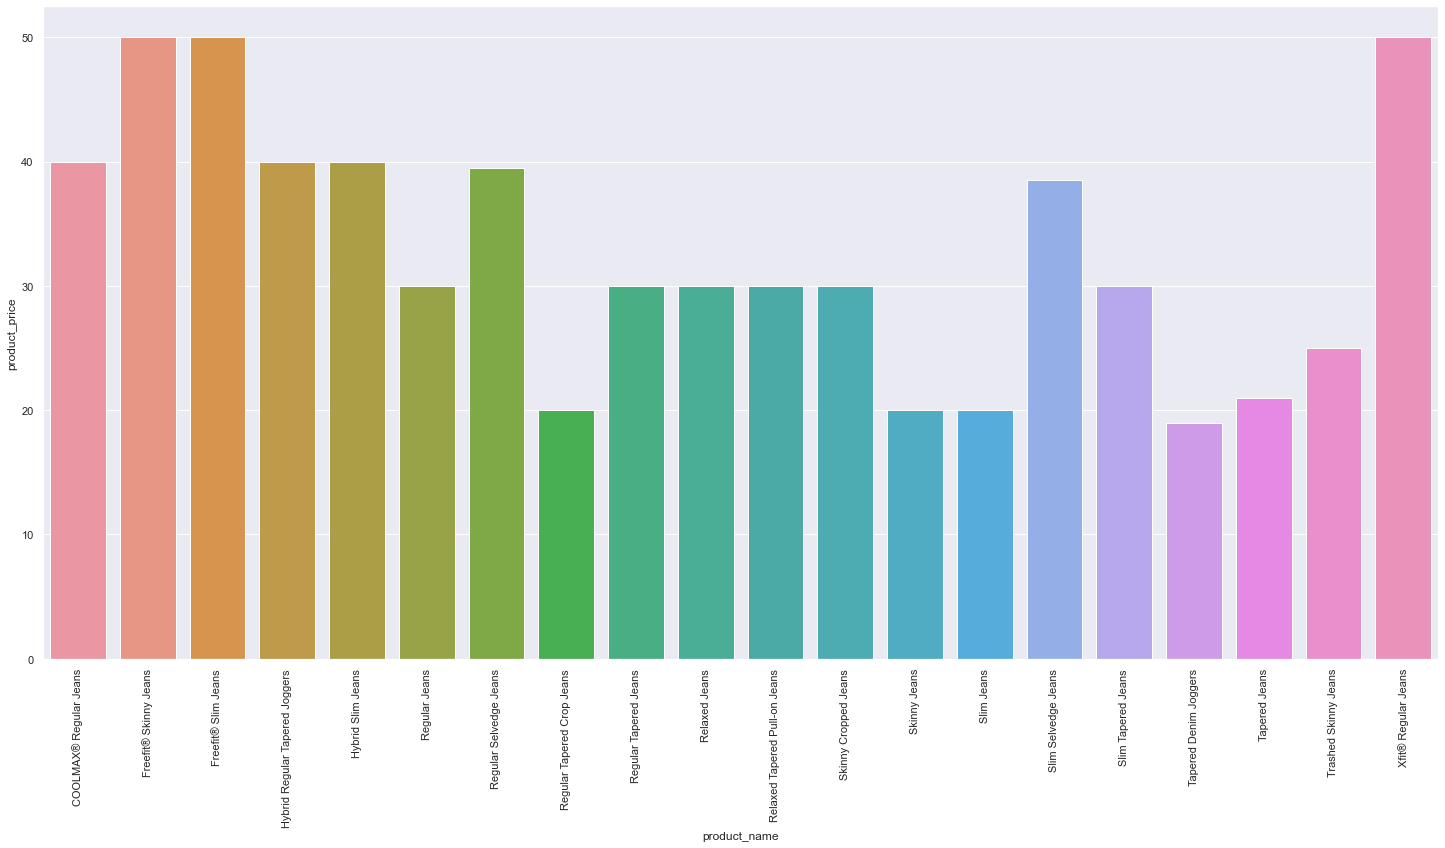

In [165]:
sns.barplot(x ='product_name' , y= 'product_price', data=aux2)
plt.xticks(rotation=90);

### 2.2.3 Number of products by colors

In [179]:
aux3 = df[['product_color','product_id']].groupby('product_color').count().reset_index()
aux3.sort_values(by=['product_id'], ascending=False)

,product_color,product_id
25,Denim blue,36
36,Light denim blue,26
0,Black,14
19,Dark denim blue,14
23,Dark gray,10
45,White,8
40,Light gray,6
14,Dark blue,6
9,Black/washed out,5
47,on Jeans,5


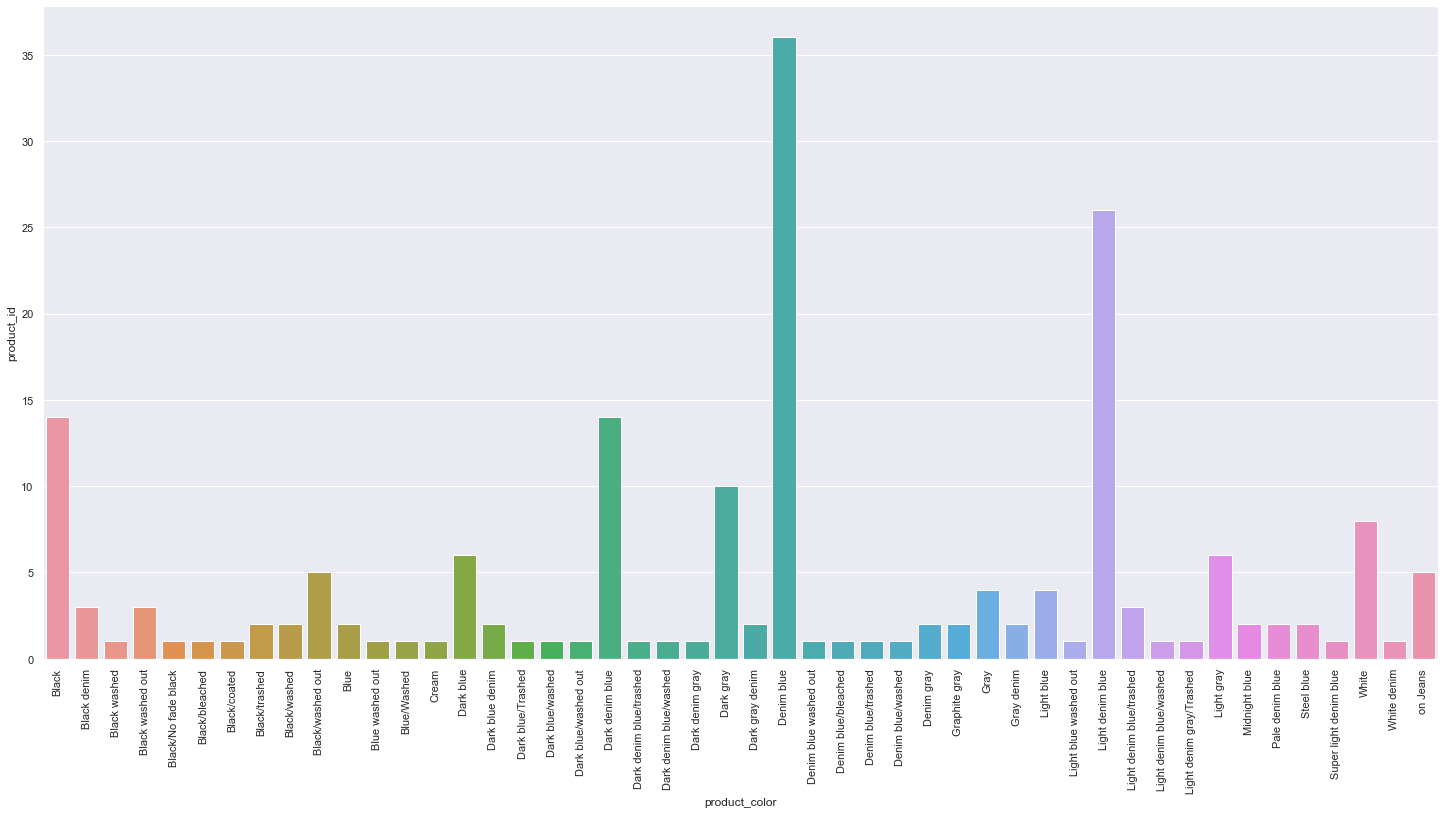

In [180]:
sns.barplot(x ='product_color' , y= 'product_id', data=aux3)
plt.xticks(rotation=90);

### 2.2.4 Number of products by product fit

In [182]:
aux4 = df[['product_fit','product_id']].groupby('product_fit').count().reset_index()
aux4.sort_values(by=['product_id'], ascending=False)

,product_fit,product_id
2,Skinny fit,96
3,Slim fit,49
0,Regular fit,38
1,Relaxed fit,8


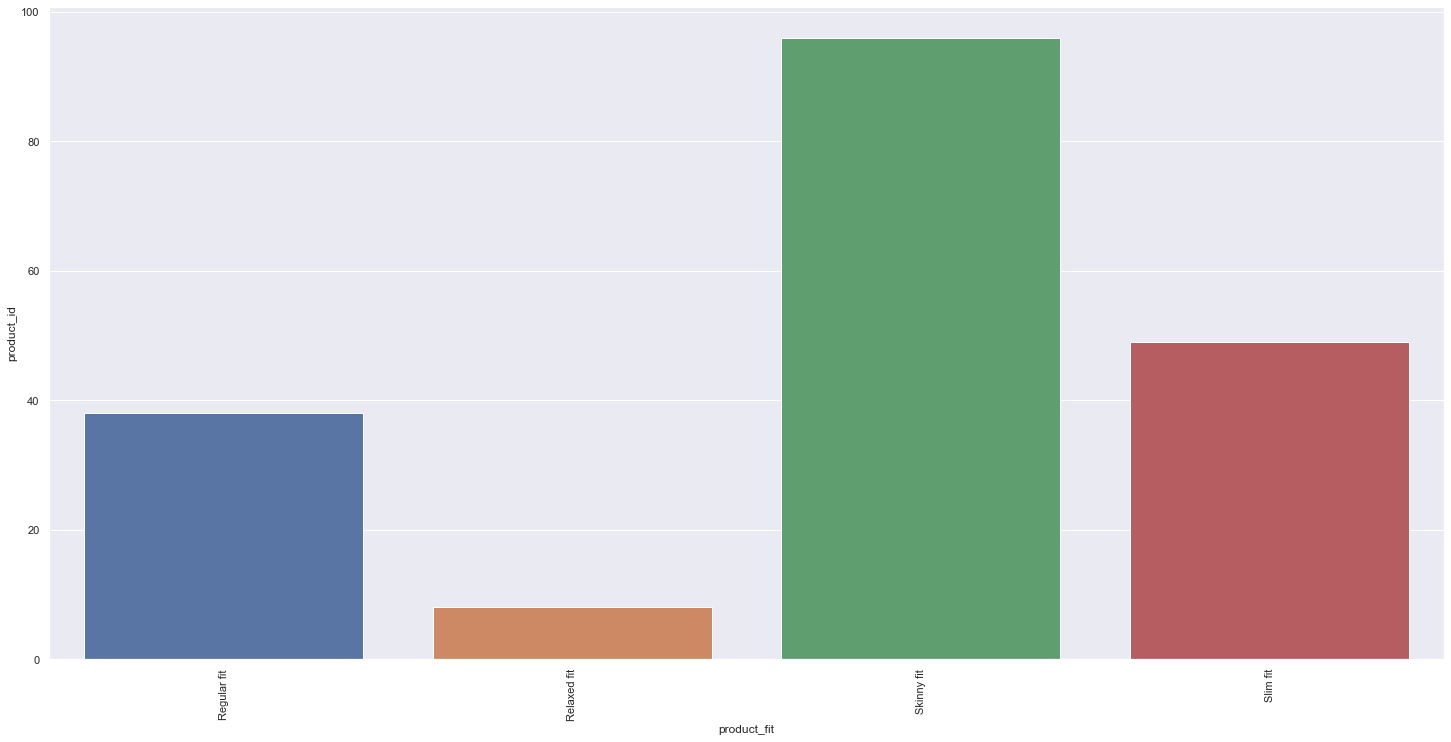

In [183]:
sns.barplot(x ='product_fit' , y= 'product_id', data=aux4)
plt.xticks(rotation=90);

### 2.2.5 Median price by product fit

In [186]:
aux5 = df[['product_fit','product_price']].groupby('product_fit').median().reset_index()

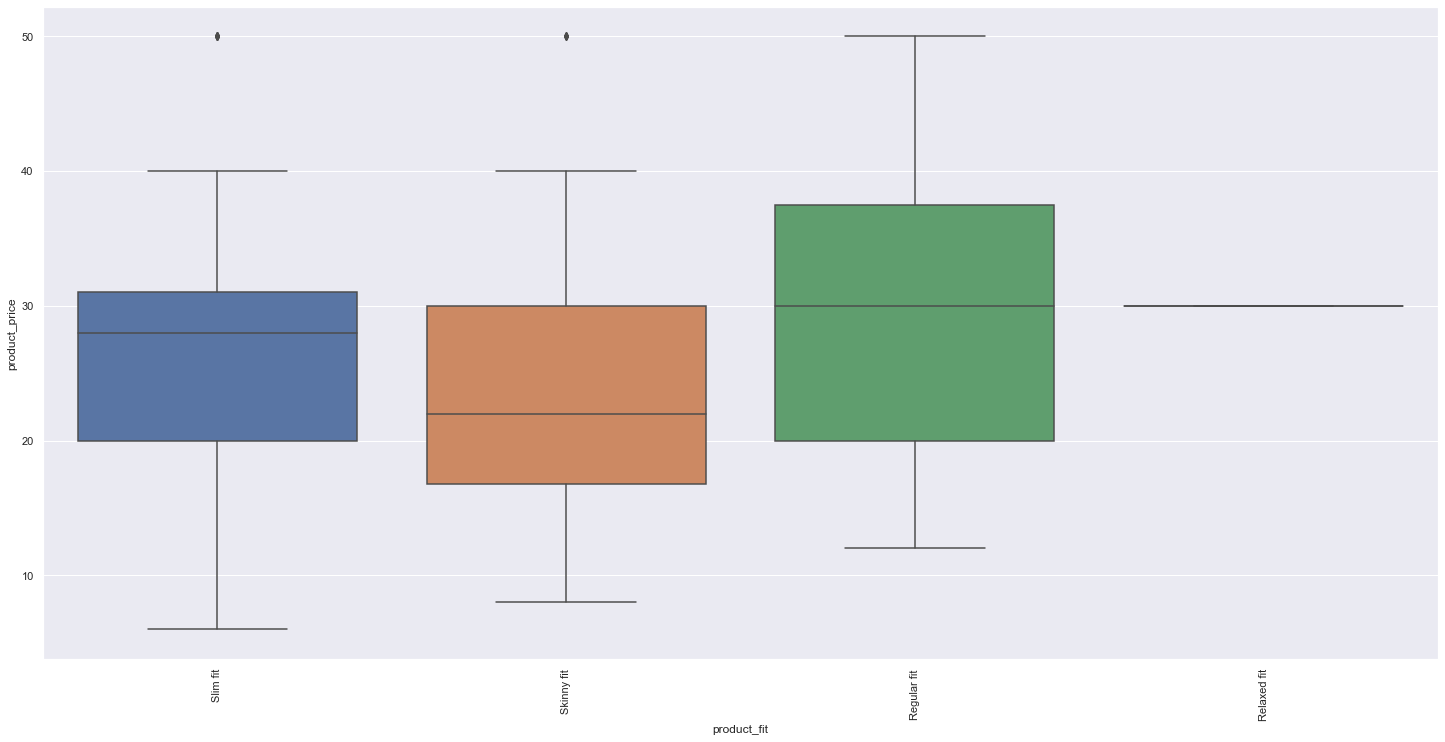

In [188]:
sns.boxplot(x ='product_fit' , y= 'product_price', data=df1)
plt.xticks(rotation=90);